In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,precision_score,recall_score,roc_auc_score,roc_curve,recall_score,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.decomposition import PCA


import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

/home/inderjeet78/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
data = pd.read_csv("creditcard.csv")
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
X = data.iloc[:,data.columns != 'Class']
Y = data.iloc[:,data.columns == 'Class']
pca = PCA(n_components=25)
X = pca.fit_transform(X)
X_train,testX,Y_train,testY = train_test_split(X,Y,test_size=0.20,random_state=21, stratify=Y)
X_train,valX,Y_train,valY = train_test_split(X_train,Y_train,test_size=0.20,random_state=21, stratify=Y_train)

In [3]:
X_train = np.array(X_train)
valX = np.array(valX)
testX = np.array(testX)
Y_train = np.array(Y_train)
valY = np.array(valY)
testY = np.array(testY)

In [4]:
input_dim = X_train.shape[1]

encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [5]:
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h7777",
                               verbose=0,monitor='val_loss',
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(valX, valX),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 182276 samples, validate on 45569 samples
Epoch 1/10
182276/182276 [==============================] - 6s 33us/step - loss: 0.9258 - acc: 0.5431 - val_loss: 0.8029 - val_acc: 0.6296
Epoch 2/10
182276/182276 [==============================] - 6s 32us/step - loss: 0.8128 - acc: 0.6327 - val_loss: 0.7745 - val_acc: 0.6316
Epoch 3/10
182276/182276 [==============================] - 6s 32us/step - loss: 0.7942 - acc: 0.6435 - val_loss: 0.7638 - val_acc: 0.6448
Epoch 4/10
182276/182276 [==============================] - 6s 33us/step - loss: 0.7840 - acc: 0.6506 - val_loss: 0.7553 - val_acc: 0.6540
Epoch 5/10
182276/182276 [==============================] - 6s 32us/step - loss: 0.7781 - acc: 0.6553 - val_loss: 0.7492 - val_acc: 0.6473
Epoch 6/10
182276/182276 [==============================] - 6s 32us/step - loss: 0.7719 - acc: 0.6602 - val_loss: 0.7467 - val_acc: 0.6685
Epoch 7/10
182276/182276 [==============================] - 6s 32us/step - loss: 0.7661 - acc: 0.6629 - val_loss: 0

In [6]:
autoencoder = load_model('model.h7777')

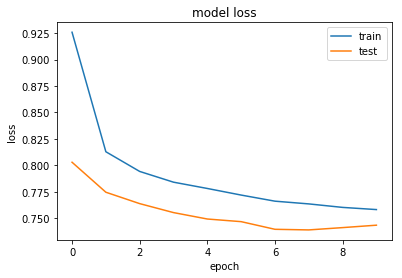

In [7]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [8]:
predictions = autoencoder.predict(testX)
mse = np.mean(np.power(testX - predictions, 2), axis=1)
print(mse.shape)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': testY.reshape(-1)})
error_df.describe()

(56962,)


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.739016,0.001720
std,2.254312,0.041443
min,0.105356,0.000000
25%,0.330509,0.000000
50%,0.466945,0.000000
75%,0.699664,0.000000
max,114.793937,1.000000


# Performance

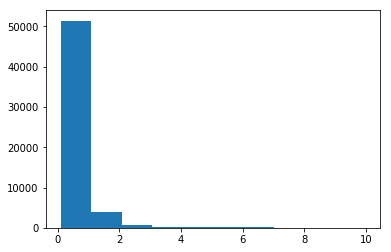

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

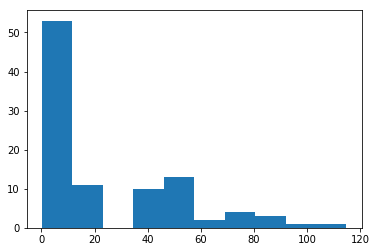

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

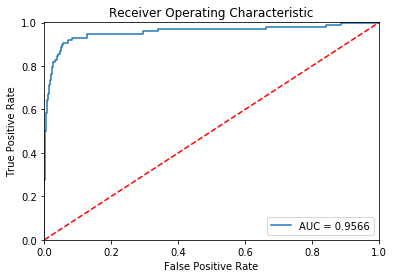

In [11]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

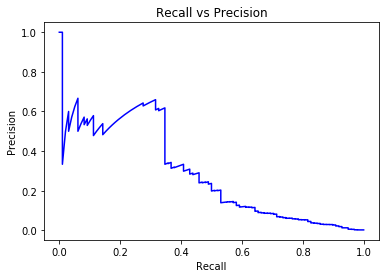

In [12]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

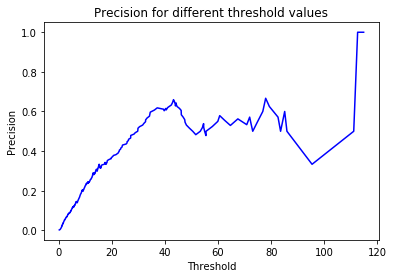

In [13]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

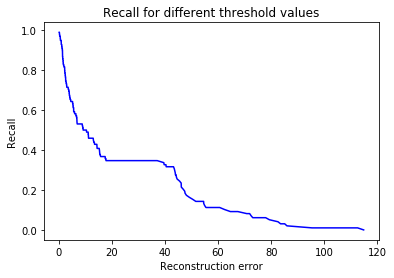

In [14]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

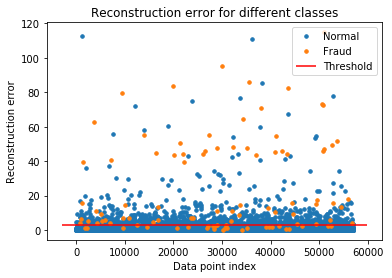

In [15]:
threshold = 2.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

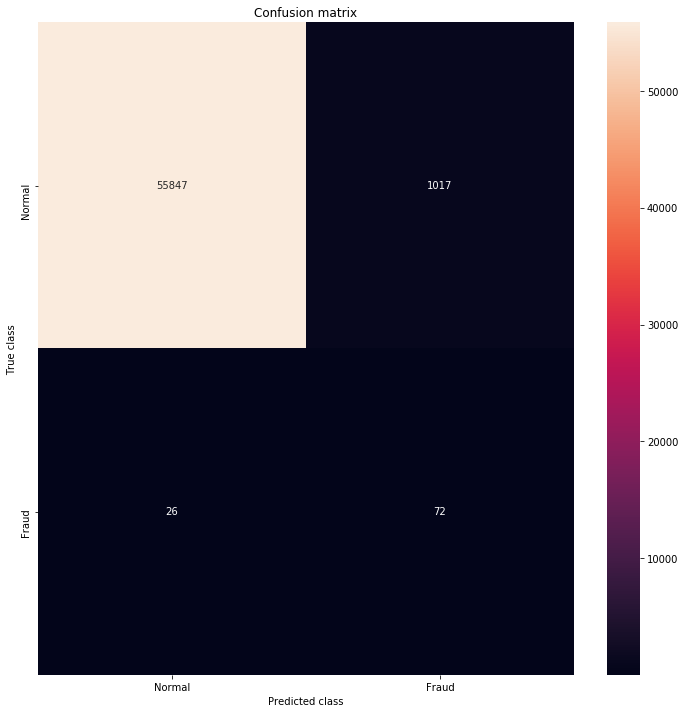

In [16]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()